In [1]:
#!pip -q install einops
import numpy as np
import torch
from torch.utils.data import DataLoader
from set_data import load_real_weather, WeatherPairs, split_windows_train_val_test
from visualization import (plot_complete_data, 
                           plot_weatherpair_panel,
                           visualize_loss, plot_ctx_and_scenarios_panel)
from utils import *
from diffusion_model import DiffusionSchedule, TinyCondUNet1D
from diffusion_model_train import train_one_epoch, eval_epoch
from diffusion_model_generate import p_sample_loop

VARS = 6
EPOCHS = 30
feature_names = ["T2M_MIN", "T2M_MAX", "PRECTOTCORR", "ALLSKY_SFC_SW_DWN", "RH2M", "WS2M"]

seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
device = "cuda" if torch.cuda.is_available() else "cpu"
print("device:", device)



device: cpu


In [2]:

X, columns = load_real_weather("../../data/data_20220630_to_20240630.csv", 
                      start_date="2022-06-30", end_date="2024-06-30")
print("Real data shape:", X.shape)  # (days, number of features)

Real data shape: (732, 6)


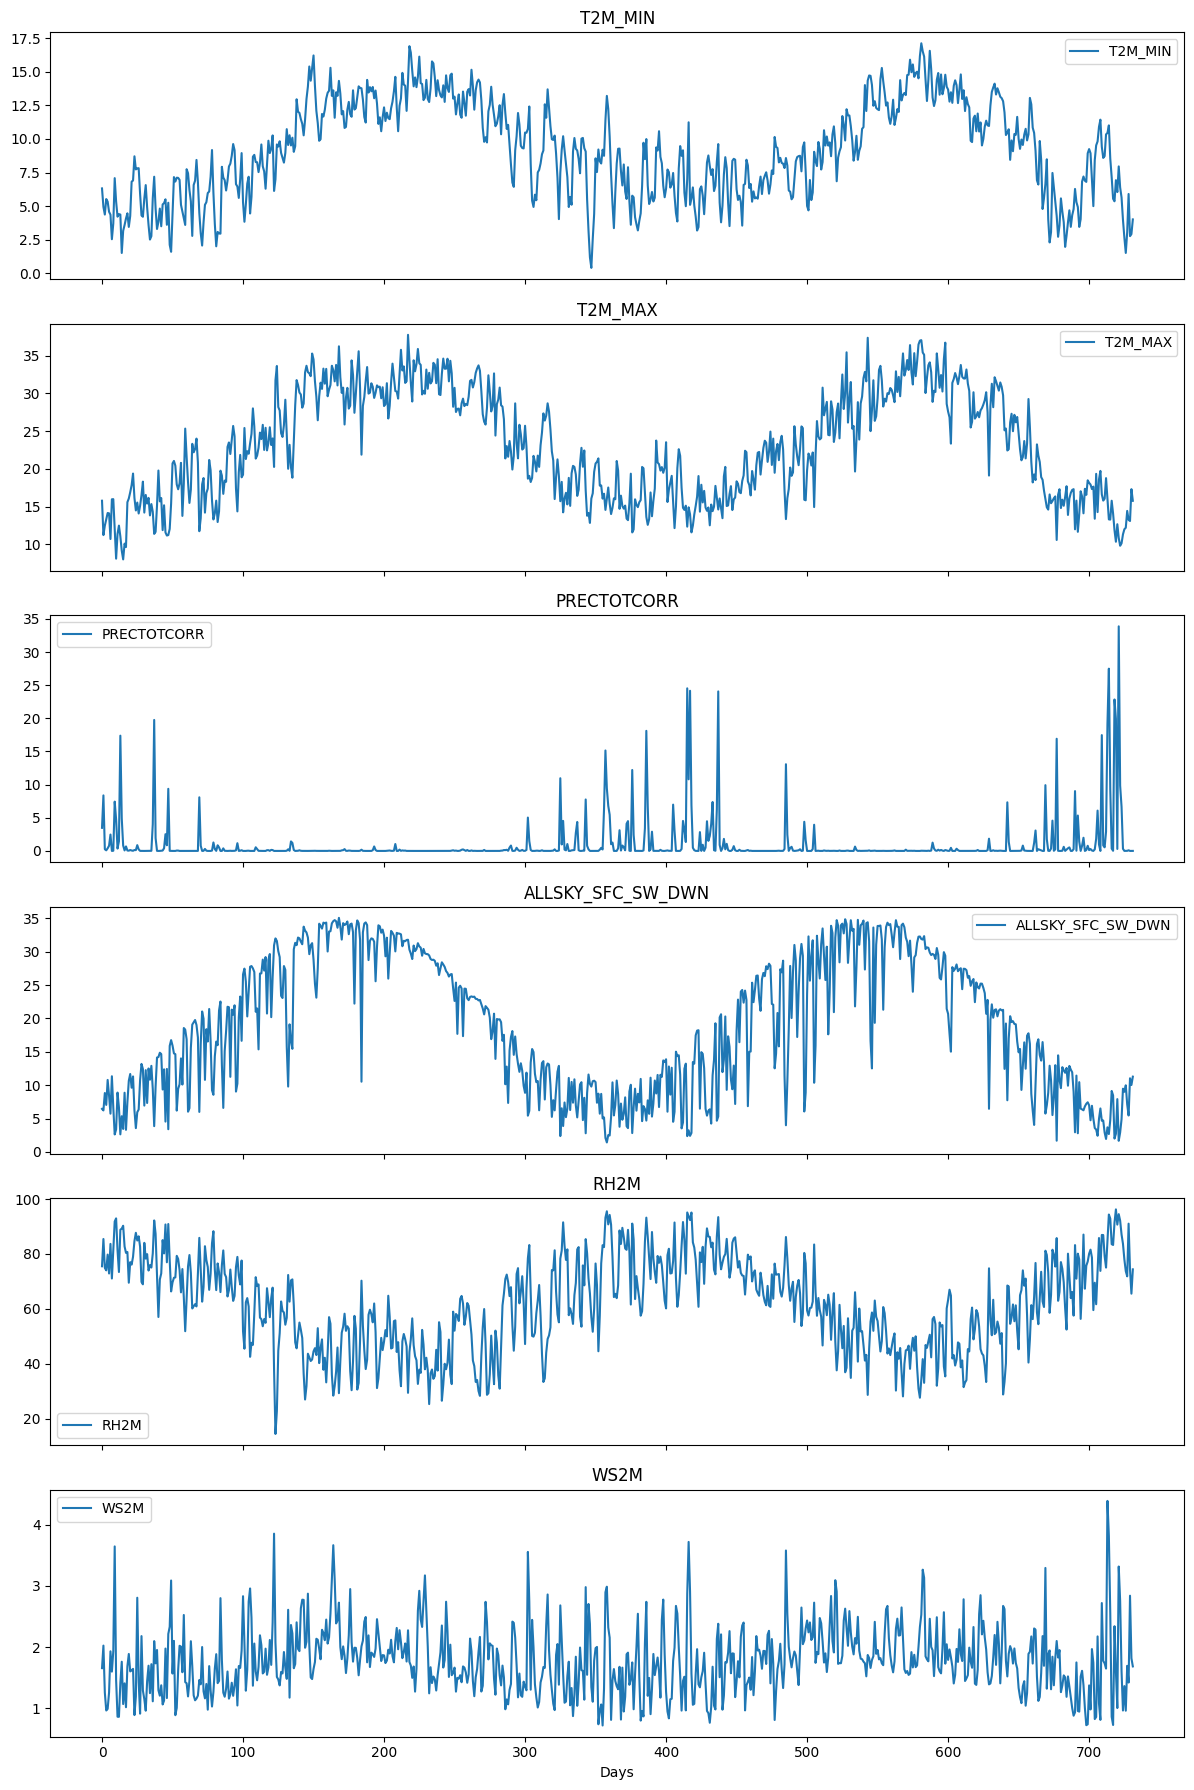

In [3]:
plot_complete_data(X, columns)

In [4]:
CTX = 30
HORIZON = 60
dataset = WeatherPairs(X, ctx=CTX, horizon=HORIZON, stride=1)
train_ds, val_ds, test_ds = split_windows_train_val_test(dataset, test_frac=0.15, val_frac=0.15, train_frac=0.7)



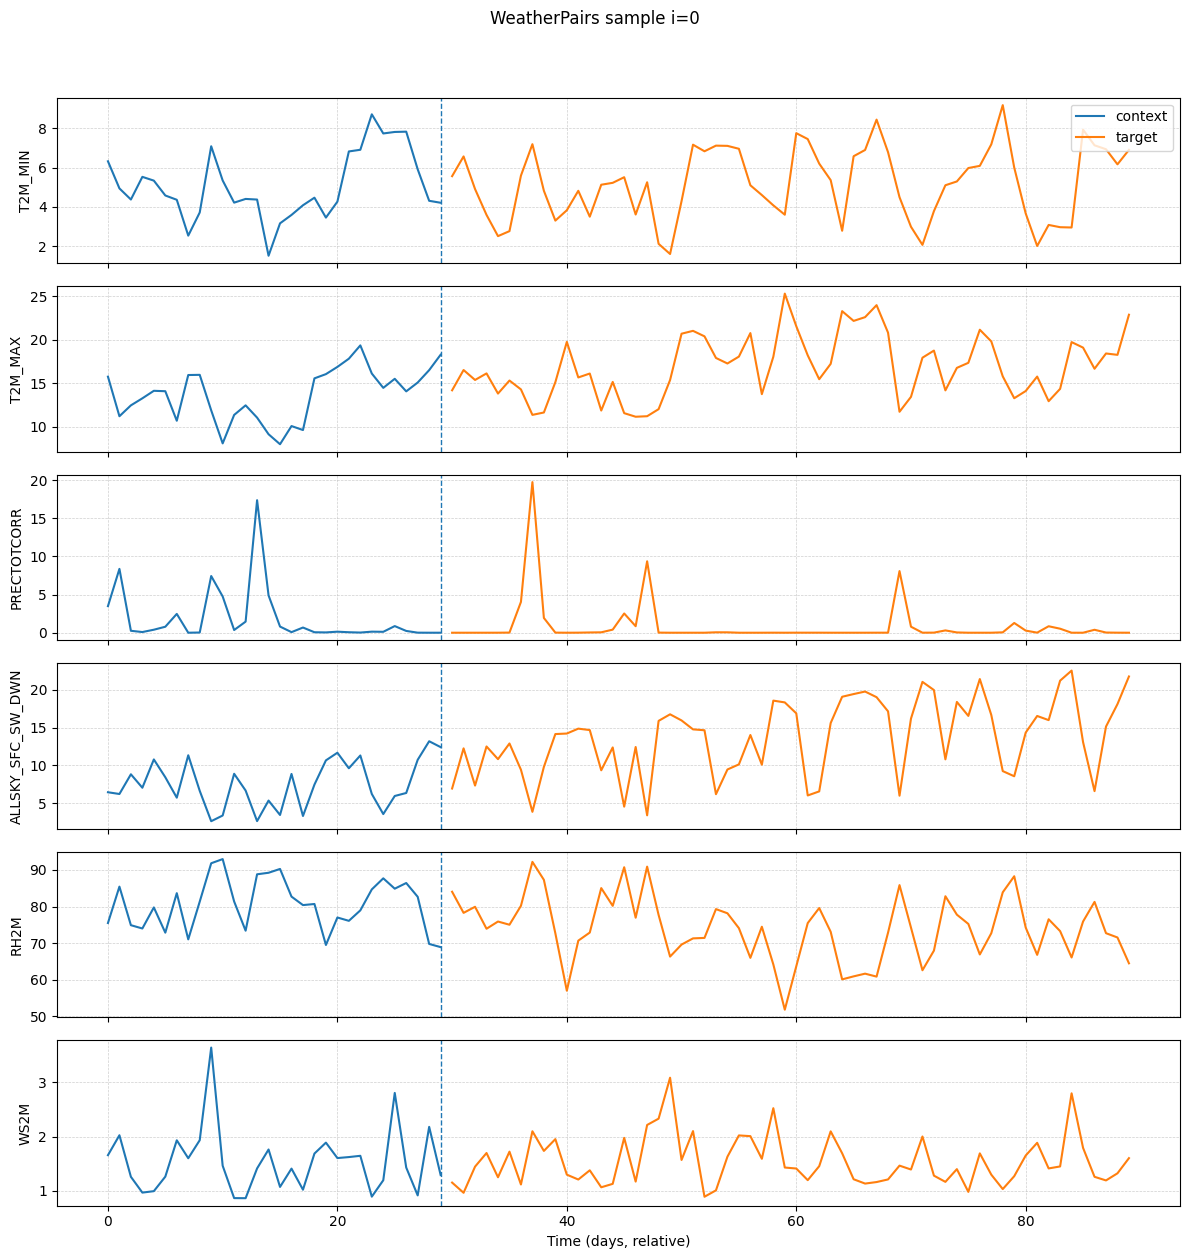

In [5]:
plot_weatherpair_panel(train_ds, i=0, feature_names=feature_names)

In [6]:
print("windows:", len(dataset))
print("train/val/test:", len(train_ds), len(val_ds), len(test_ds))

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, drop_last=True)
val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False, drop_last=False)
test_loader  = DataLoader(test_ds, batch_size=32, shuffle=False, drop_last=False)


windows: 643
train/val/test: 271 96 96


In [7]:
mean, std = fit_standardizer(train_ds)
mean_t = torch.tensor(mean, device=device)
std_t = torch.tensor(std, device=device)
print("mean:", mean, "\nstd:", std)

mean: [10.362893   26.225946    0.23605916 23.189392   54.68049     1.8335068 ] 
std: [ 3.4586256  6.293054   1.2695119  8.737333  15.431707   0.5138939]


In [8]:
sched = DiffusionSchedule(T=100)

In [9]:
model = TinyCondUNet1D(in_vars=VARS, ctx_vars=VARS).to(device)


epoch 01 | train 0.9924 | val 0.9197
epoch 02 | train 0.8127 | val 0.8636
epoch 03 | train 0.6920 | val 0.8092
epoch 04 | train 0.6118 | val 0.7176
epoch 05 | train 0.5460 | val 0.7135
epoch 06 | train 0.5495 | val 0.6814
epoch 07 | train 0.5164 | val 0.6582
epoch 08 | train 0.4580 | val 0.7111
epoch 09 | train 0.4811 | val 0.6100
epoch 10 | train 0.4569 | val 0.6015
epoch 11 | train 0.4495 | val 0.6387
epoch 12 | train 0.4735 | val 0.6009
epoch 13 | train 0.4364 | val 0.5709
epoch 14 | train 0.3994 | val 0.6246
epoch 15 | train 0.4006 | val 0.5443
epoch 16 | train 0.3709 | val 0.6202
epoch 17 | train 0.3824 | val 0.5605
epoch 18 | train 0.3783 | val 0.5629
epoch 19 | train 0.3780 | val 0.5743
epoch 20 | train 0.3558 | val 0.5514
epoch 21 | train 0.3496 | val 0.6361
epoch 22 | train 0.3368 | val 0.5590
epoch 23 | train 0.3251 | val 0.6195
epoch 24 | train 0.3490 | val 0.5575
epoch 25 | train 0.3597 | val 0.6266
epoch 26 | train 0.3504 | val 0.6003
epoch 27 | train 0.3417 | val 0.5822
e

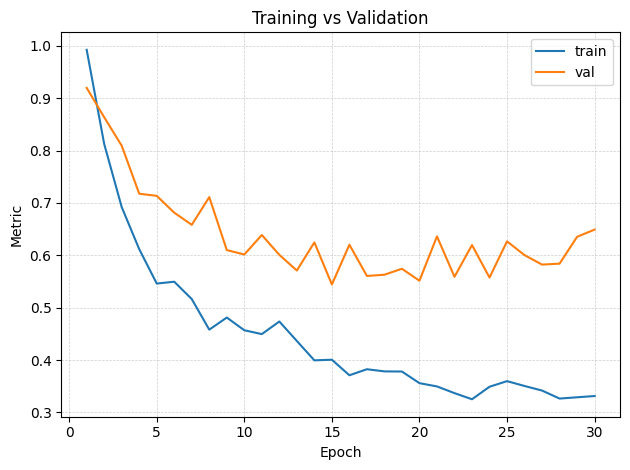

In [10]:
opt = torch.optim.AdamW(model.parameters(), lr=2e-4, weight_decay=1e-4)

train_hist, val_hist = [], []

for e in range(1, EPOCHS + 1):
    tr = train_one_epoch(opt, model, sched, device, train_loader, mean_t, std_t)
    va = eval_epoch(model, device, val_loader, sched, mean_t, std_t)

    train_hist.append(float(tr))
    val_hist.append(float(va))

    print(f"epoch {e:02d} | train {tr:.4f} | val {va:.4f}")

visualize_loss(EPOCHS, train_hist, val_hist)


In [11]:
ctx_raw, tgt_raw = val_ds[0]
ctx_raw = ctx_raw.unsqueeze(0)  # (1,60,4)
tgt_raw = tgt_raw.numpy()       # (60,4)

scens = p_sample_loop(ctx_raw, model, device, sched, HORIZON, VARS, 
                      mean_t, std_t, n_scenarios=20).numpy() 
days = np.arange(HORIZON)


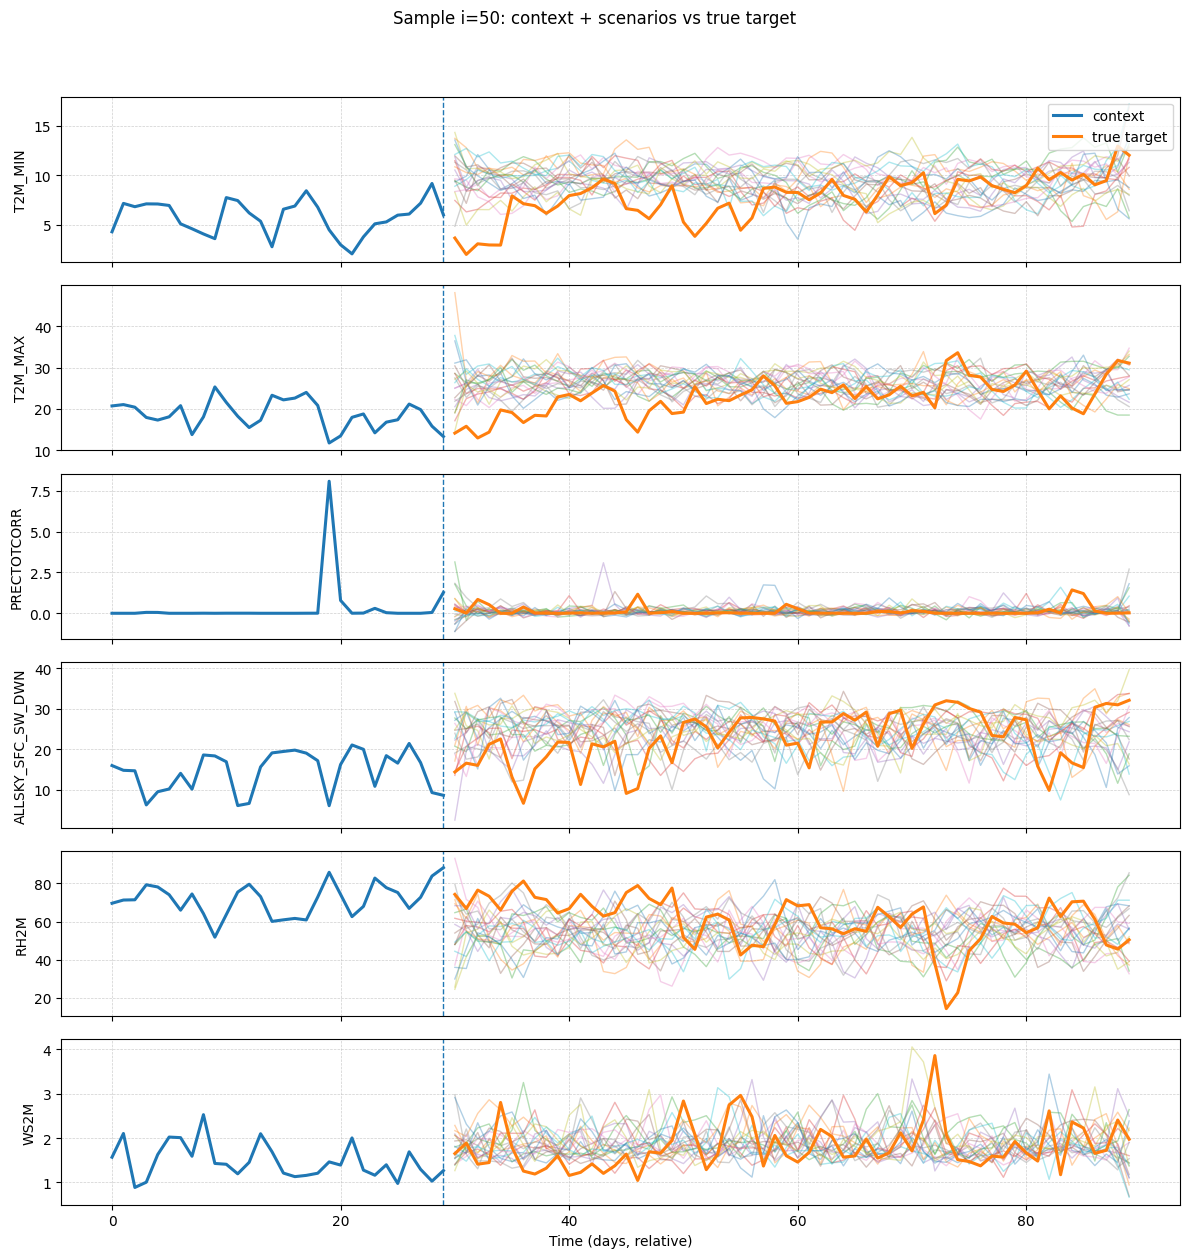

In [15]:
# Get one validation sample
ctx_raw, tgt_raw = val_ds[0]
ctx_raw = ctx_raw.unsqueeze(0)  # (1,CTX,VARS)

# Generate scenarios: (n_scenarios, HORIZON, VARS)
scens = p_sample_loop(ctx_raw, model, device, sched, HORIZON, VARS,
                      mean_t, std_t, n_scenarios=20).detach().cpu().numpy()

plot_ctx_and_scenarios_panel(
    dataset,
    50,
    scens,
    feature_names=feature_names,
    max_scen_to_plot=100
)


In [ ]:
np.save("scenarios.npy", scens)

In [22]:
Omega = np.load("scenarios.npy")
Omega

array([[[ 1.37255878e+01,  4.81660156e+01, -3.76261324e-01,
          2.10255432e+01,  6.93762894e+01,  2.28412247e+00],
        [ 1.27854424e+01,  2.69082832e+01, -2.01572537e-01,
          3.06093826e+01,  6.17694054e+01,  1.77102172e+00],
        [ 1.07203960e+01,  2.14265518e+01,  3.28497708e-01,
          2.09503956e+01,  7.45763016e+01,  1.66102827e+00],
        ...,
        [ 1.09977045e+01,  2.82833481e+01,  8.86609405e-02,
          2.87197762e+01,  5.04460754e+01,  2.18436003e+00],
        [ 1.03428392e+01,  3.07177811e+01,  1.38842046e-01,
          3.28549423e+01,  4.21744003e+01,  2.58143282e+00],
        [ 8.58259583e+00,  3.32010269e+01, -3.55772942e-01,
          3.38535385e+01,  3.72624550e+01,  2.16784048e+00]],

       [[ 1.30941486e+01,  2.85966206e+01,  3.14101338e+00,
          2.07353096e+01,  6.46942596e+01,  1.79835832e+00],
        [ 1.09619894e+01,  2.63350620e+01, -4.34101969e-01,
          1.93782005e+01,  6.65771637e+01,  1.88748360e+00],
        [ 8.94563